In [79]:
import cv2 as cv
import numpy as np 
import matplotlib.pyplot as plt

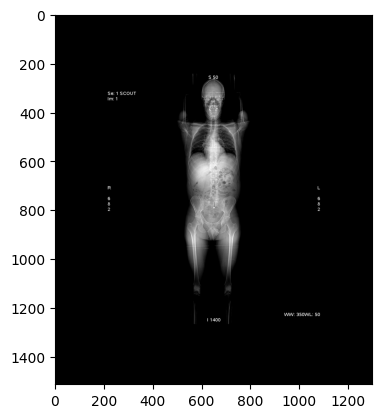

In [83]:
img = cv.imread('C:\\main\\Medycyna\\tomograf\\zdjecia\\CT_ScoutView-large.jpg', cv.IMREAD_GRAYSCALE)
plt.imshow(img, cmap='gray')

In [ ]:
def Bresenham(x1, y1, x2, y2):
    